In [1]:
import math
import torch
from torch import nn

In [11]:
import inspect


def psp(*variables):
    """Print the shape of the given variables"""

    # Retrieve the caller's frame and local variables
    frame = inspect.currentframe().f_back
    local_vars = frame.f_locals
    for variable in variables:
        # Find the variable name(s) corresponding to the given variable
        var_names = [name for name, val in local_vars.items() if val is variable]
        # Print the variable name and its shape
        if var_names:
            print(f"{var_names[0]}.shape={variable.shape}")
        else:
            print("Variable name not found")
    print()

In [12]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline


def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats("svg")


def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams["figure.figsize"] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(
    X,
    Y=None,
    xlabel=None,
    ylabel=None,
    legend=[],
    xlim=None,
    ylim=None,
    xscale="linear",
    yscale="linear",
    fmts=("-", "m--", "g-.", "r:"),
    figsize=(3.5, 2.5),
    axes=None,
):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""

    def has_one_axis(X):  # True if X (tensor or list) has 1 axis
        return (
            hasattr(X, "ndim")
            and X.ndim == 1
            or isinstance(X, list)
            and not hasattr(X[0], "__len__")
        )

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None:
        axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt) if len(x) else axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

# 注意力评分函数

:label:`sec_attention-scoring-functions`

:numref:`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
:eqref:`eq_nadaraya-watson-gaussian`中的
高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到 softmax 函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现
:numref:`fig_qkv`中的注意力机制框架。
:numref:`fig_attention_output`说明了
如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](img/attention-output.svg)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过 softmax 运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


## [**掩蔽 softmax 操作**]

正如上面提到的，softmax 操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在 :numref:`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算 softmax 时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数
实现了这样的*掩蔽 softmax 操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为 0。


In [13]:
def sequence_mask_2d(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.
    X: 2D tensor with the last dimension to be masked
    valid_lens: 1D tensor for the valid length of each X's last dimension
    value: value to be filled in the masked region
    """
    assert X.dim() == 2, "X must be 2D tensor"
    assert valid_len.dim() == 1, "valid_len must be 1D tensor"
    assert X.size(0) == valid_len.size(
        0
    ), "batch size of X and valid_len must be the same"

    maxlen = X.size(-1)
    pos = torch.arange(maxlen, dtype=torch.float32, device=X.device).unsqueeze(0)
    mask = pos >= valid_len.unsqueeze(-1)
    X[mask] = value
    return X


def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis.
    X: 3D tensor in format (batch_size, num_queries, num_inputs)
    valid_lens: 1D or 2D tensor in format (batch_size) or (batch_size, num_queries)
    """
    assert X.dim() == 3, "X must be 3D tensor"
    assert valid_lens.dim() in [1, 2], "valid_lens must be 1D or 2D tensor"

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        X_2d = X.reshape(-1, shape[-1])
        if valid_lens.dim() == 1:
            # repeat valid_lens for each query
            vl_1d = valid_lens.repeat_interleave(shape[1])
        else:
            vl_1d = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X_2d = sequence_mask_2d(X_2d, vl_1d, value=-1e6)
        return nn.functional.softmax(X_2d.reshape(shape), dim=-1)

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4857, 0.5143, 0.0000, 0.0000],
         [0.4893, 0.5107, 0.0000, 0.0000]],

        [[0.1952, 0.3491, 0.4557, 0.0000],
         [0.2974, 0.4204, 0.2822, 0.0000]]])

In [15]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4300, 0.2306, 0.3393, 0.0000]],

        [[0.5880, 0.4120, 0.0000, 0.0000],
         [0.1799, 0.2751, 0.3371, 0.2079]]])

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [16]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    # return shape: (batch_size, no. of queries, value dimension)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [17]:
DPA_batch = 2
DPA_num_q = 3
DPA_size_qk = 4
DPA_num_kv = 10
DPA_size_v = 6

queries = torch.normal(0, 1, (DPA_batch, DPA_num_q, DPA_size_qk))
keys = torch.ones((DPA_batch, DPA_num_kv, DPA_size_qk))
values = (
    torch.arange(DPA_num_kv * DPA_size_v, dtype=torch.float32)
    .reshape(-1, DPA_num_kv, DPA_size_v)
    .repeat(DPA_batch, 1, 1)
)
valid_lens = torch.randint(0, DPA_num_kv, (DPA_batch,))
psp(queries, keys, values, valid_lens)

net = DotProductAttention(dropout=0.5)
print(f"{net.eval()=}")

out = net(queries, keys, values, valid_lens)
psp(out)

del queries, keys, values, valid_lens, out

queries.shape=torch.Size([2, 3, 4])
keys.shape=torch.Size([2, 10, 4])
values.shape=torch.Size([2, 10, 6])
valid_lens.shape=torch.Size([2])

net.eval()=DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)
out.shape=torch.Size([2, 3, 6])



# 多头注意力

:label:`sec_multihead-attention`

在实践中，当给定相同的查询、键和值的集合时，
我们希望模型可以基于相同的注意力机制学习到不同的行为，
然后将不同的行为作为知识组合起来，
捕获序列内各种范围的依赖关系
（例如，短距离依赖和长距离依赖关系）。
因此，允许注意力机制组合使用查询、键和值的不同
_子空间表示_（representation subspaces）可能是有益的。

为此，与其只使用单独一个注意力汇聚，
我们可以用独立学习得到的$h$组不同的
_线性投影_（linear projections）来变换查询、键和值。
然后，这$h$组变换后的查询、键和值将并行地送到注意力汇聚中。
最后，将这$h$个注意力汇聚的输出拼接在一起，
并且通过另一个可以学习的线性投影进行变换，
以产生最终输出。
这种设计被称为*多头注意力*（multihead attention）
:cite:`Vaswani.Shazeer.Parmar.ea.2017`。
对于$h$个注意力汇聚输出，每一个注意力汇聚都被称作一个*头*（head）。
:numref:`fig_multi-head-attention`
展示了使用全连接层来实现可学习的线性变换的多头注意力。

![多头注意力：多个头连结然后线性变换](img/multi-head-attention.svg)
:label:`fig_multi-head-attention`

## 模型

在实现多头注意力之前，让我们用数学语言将这个模型形式化地描述出来。
给定查询$\mathbf{q} \in \mathbb{R}^{d_q}$、
键$\mathbf{k} \in \mathbb{R}^{d_k}$和
值$\mathbf{v} \in \mathbb{R}^{d_v}$，
每个注意力头$\mathbf{h}_i$（$i = 1, \ldots, h$）的计算方法为：

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

其中，可学习的参数包括
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$、
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$和
$\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$，
以及代表注意力汇聚的函数$f$。
$f$可以是 :numref:`sec_attention-scoring-functions`中的
加性注意力和缩放点积注意力。
多头注意力的输出需要经过另一个线性转换，
它对应着$h$个头连结后的结果，因此其可学习参数是
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$：

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

基于这种设计，每个头都可能会关注输入的不同部分，
可以表示比简单加权平均值更复杂的函数。


### 多头注意力的尺寸

在实现过程中通常[**选择缩放点积注意力作为每一个注意力头**]。
为了避免计算代价和参数代价的大幅增长，我们设定$p_q = p_k = p_v = p_o / h$。
值得注意的是，如果将查询、键和值的线性变换的输出数量设置为
$p_q h = p_k h = p_v h = p_o$，
则可以并行计算$h$个头。
在下面的实现中，$p_o$是通过参数`num_hiddens`指定的。

也就是 num_pkv \* num_heads = num_hiddens，在实现中多头中的 W 是被拼接到一起的，这也就造成了下图中的尺寸变换
![关于多头注意力的尺寸变换](img/multi-head-attention-shape.png)


In [18]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention.

    Defined in :numref:`sec_multihead-attention`"""

    def __init__(self, num_hiddens, num_heads, dropout, bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads.

        Defined in :numref:`sec_multihead-attention`"""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv.
            from (batch_size * num_of_heads, no. of queries or key-value pairs,
              num_of_hiddens/num_of_heads)
            to   (batch_size, no. of queries or key-value pairs, num_of_hiddens)
        Defined in :numref:`sec_multihead-attention`"""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

In [19]:
MHA_batch = 2
MHA_heads = 5
MHA_size_qkv = 20

# the dimension of the query, key, and value is the same
MHA_hiddens = MHA_size_qkv * MHA_heads
MHA_queries = MHA_hiddens
MHA_keys = MHA_hiddens
MHA_values = MHA_hiddens

MHA_num_q = 4
MHA_num_kv = 6

Q = torch.normal(0, 1, (MHA_batch, MHA_num_q, MHA_hiddens))
K = torch.ones((MHA_batch, MHA_num_kv, MHA_hiddens))
V = torch.ones((MHA_batch, MHA_num_kv, MHA_hiddens))
valid_lens = torch.randint(0, MHA_num_kv, (MHA_batch,))
psp(Q, K, V, valid_lens)

net = MultiHeadAttention(MHA_hiddens, MHA_heads, 0.5)
print(f"{net.eval()=}")

mha = net(Q, K, V, valid_lens)
psp(mha)

del Q, K, V, valid_lens, mha

Q.shape=torch.Size([2, 4, 100])
K.shape=torch.Size([2, 6, 100])
V.shape=torch.Size([2, 6, 100])
valid_lens.shape=torch.Size([2])

net.eval()=MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_k): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_v): LazyLinear(in_features=0, out_features=100, bias=False)
  (W_o): LazyLinear(in_features=0, out_features=100, bias=False)
)
mha.shape=torch.Size([2, 4, 100])



# 自注意力和位置编码

:label:`sec_self-attention-and-positional-encoding`

在深度学习中，经常使用卷积神经网络（CNN）或循环神经网络（RNN）对序列进行编码。
想象一下，有了注意力机制之后，我们将词元序列输入注意力池化中，
以便同一组词元同时充当查询、键和值。
具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出。
由于查询、键和值来自同一组输入，因此被称为
_自注意力_（self-attention）
:cite:`Lin.Feng.Santos.ea.2017,Vaswani.Shazeer.Parmar.ea.2017`，
也被称为*内部注意力*（intra-attention） :cite:`Cheng.Dong.Lapata.2016,Parikh.Tackstrom.Das.ea.2016,Paulus.Xiong.Socher.2017`。
本节将使用自注意力进行序列编码，以及如何使用序列的顺序作为补充信息。


## 比较卷积神经网络、循环神经网络和自注意力

:label:`subsec_cnn-rnn-self-attention`

接下来比较下面几个架构，目标都是将由$n$个词元组成的序列映射到另一个长度相等的序列，其中的每个输入词元或输出词元都由$d$维向量表示。具体来说，将比较的是卷积神经网络、循环神经网络和自注意力这几个架构的计算复杂性、顺序操作和最大路径长度。请注意，顺序操作会妨碍并行计算，而任意的序列位置组合之间的路径越短，则能更轻松地学习序列中的远距离依赖关系 :cite:`Hochreiter.Bengio.Frasconi.ea.2001`。

![比较卷积神经网络（填充词元被忽略）、循环神经网络和自注意力三种架构](img/cnn-rnn-self-attention.svg)
:label:`fig_cnn-rnn-self-attention`

考虑一个卷积核大小为$k$的卷积层。
在后面的章节将提供关于使用卷积神经网络处理序列的更多详细信息。
目前只需要知道的是，由于序列长度是$n$，输入和输出的通道数量都是$d$，
所以卷积层的计算复杂度为$\mathcal{O}(knd^2)$。
如 :numref:`fig_cnn-rnn-self-attention`所示，
卷积神经网络是分层的，因此为有$\mathcal{O}(1)$个顺序操作，
最大路径长度为$\mathcal{O}(n/k)$。
例如，$\mathbf{x}_1$和$\mathbf{x}_5$处于
:numref:`fig_cnn-rnn-self-attention`中卷积核大小为 3 的双层卷积神经网络的感受野内。

当更新循环神经网络的隐状态时，
$d \times d$权重矩阵和$d$维隐状态的乘法计算复杂度为$\mathcal{O}(d^2)$。
由于序列长度为$n$，因此循环神经网络层的计算复杂度为$\mathcal{O}(nd^2)$。
根据 :numref:`fig_cnn-rnn-self-attention`，
有$\mathcal{O}(n)$个顺序操作无法并行化，最大路径长度也是$\mathcal{O}(n)$。

在自注意力中，查询、键和值都是$n \times d$矩阵。
考虑 :eqref:`eq_softmax_QK_V`中缩放的”点－积“注意力，
其中$n \times d$矩阵乘以$d \times n$矩阵。
之后输出的$n \times n$矩阵乘以$n \times d$矩阵。
因此，自注意力具有$\mathcal{O}(n^2d)$计算复杂性。
正如在 :numref:`fig_cnn-rnn-self-attention`中所讲，
每个词元都通过自注意力直接连接到任何其他词元。
因此，有$\mathcal{O}(1)$个顺序操作可以并行计算，
最大路径长度也是$\mathcal{O}(1)$。

总而言之，卷积神经网络和自注意力都拥有并行计算的优势，
而且自注意力的最大路径长度最短。
但是因为其计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢。


## [**位置编码**]

:label:`subsec_positional-encoding`

在处理词元序列时，循环神经网络是逐个的重复地处理词元的，
而自注意力则因为并行计算而放弃了顺序操作。
为了使用序列的顺序信息，通过在输入表示中添加
_位置编码_（positional encoding）来注入绝对的或相对的位置信息。
位置编码可以通过学习得到也可以直接固定得到。
接下来描述的是基于正弦函数和余弦函数的固定位置编码
:cite:`Vaswani.Shazeer.Parmar.ea.2017`。

假设输入表示$\mathbf{X} \in \mathbb{R}^{n \times d}$
包含一个序列中$n$个词元的$d$维嵌入表示。
位置编码使用相同形状的位置嵌入矩阵
$\mathbf{P} \in \mathbb{R}^{n \times d}$输出$\mathbf{X} + \mathbf{P}$，
矩阵第$i$行、第$2j$列和$2j+1$列上的元素为：

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$
:eqlabel:`eq_positional-encoding-def`

乍一看，这种基于三角函数的设计看起来很奇怪。
在解释这个设计之前，让我们先在下面的`PositionalEncoding`类中实现它。


In [20]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""

    def __init__(self, num_hiddens, num_inputs, dropout, pow_base=10000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # create a metrix based on input position and hiddens, shape: (num_inputs, num_hiddens / 2)
        X_n = torch.arange(num_inputs, dtype=torch.float32).reshape(-1, 1)
        X_f = torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens
        X = X_n / torch.pow(pow_base, X_f)

        # Create a long enough P which should accommodate possible input lengths
        self.P = torch.zeros((1, num_inputs, num_hiddens))
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, : X.shape[1], :].to(X.device)
        return self.dropout(X)

Variable name not found



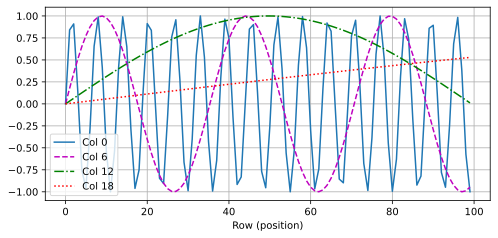

In [22]:
PE_hiddens, PE_inputs = 32, 100
pos_encoding = PositionalEncoding(PE_hiddens, PE_inputs, 0)
psp(pos_encoding.P)

X = pos_encoding(torch.zeros((1, PE_inputs, PE_hiddens)))
P = pos_encoding.P[:, : X.shape[1], :]

Cols = torch.arange(0, PE_hiddens, 6)
plot(
    torch.arange(PE_inputs),
    P[0, :, Cols].T,
    xlabel="Row (position)",
    figsize=(8, 3.5),
    legend=["Col %d" % d for d in Cols],
)

# Transformer

:label:`sec_transformer`

:numref:`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`，Transformer 模型完全基于注意力机制，没有任何卷积层或循环神经网络层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管 Transformer 最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer 作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，Transformer 是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于 Bahdanau 注意力实现的序列到序列的学习相比，Transformer 的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](img/transformer.svg)
:width:`500px`
:label:`fig_transformer`

图 :numref:`fig_transformer`中概述了 Transformer 的架构。从宏观角度来看，Transformer 的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在 Transformer 中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization） :cite:`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，Transformer 编码器都将输出一个$d$维表示向量。

Transformer 解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力 :numref:`sec_multihead-attention`和位置编码 :numref:`subsec_positional-encoding`。接下来将实现 Transformer 模型的剩余部分。


## **基于位置的前馈网络**

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [23]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""

    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

## **残差连接和层规范化**

现在让我们关注 :numref:`fig_transformer`中的*加法和规范化*（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

:numref:`sec_batch_norm`中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

![normalization方法](img/normalization_methods_comparison.png)


In [24]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""

    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

## 编码器

有了组成 Transformer 编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

![EncoderBlock](img/transformer_encoder_block.png)


In [25]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""

    def __init__(
        self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False
    ):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [26]:
class TransformerEncoder(nn.Module):
    """The Transformer encoder."""

    def __init__(
        self,
        vocab_size,
        num_hiddens,
        max_inputs,
        ffn_num_hiddens,
        num_heads,
        num_blks,
        dropout,
        use_bias=False,
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, max_inputs, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                "block" + str(i),
                TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias
                ),
            )

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

## 解码器

如 :numref:`fig_transformer`所示，[**Transformer 解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

![DecoderBlock](img/transformer_decoder_block.png)

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [27]:
class DecoderBlock(nn.Module):
    """The Transformer decoder block on i-th."""

    def __init__(
        self,
        i,
        num_heads,
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        dropout,
        use_bias=False,
    ):
        super().__init__()

        self.i = i
        self.heads = num_heads
        self.self_attention = MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias
        )
        self.self_addnorm = AddNorm(norm_shape, dropout)
        self.cross_attention = MultiHeadAttention(
            num_hiddens, num_heads, dropout, use_bias
        )
        self.cross_addnorm = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.ffn_addnorm = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(
                batch_size, 1
            )
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.self_attention(X, key_values, key_values, dec_valid_lens)
        Y = self.self_addnorm(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.cross_attention(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.cross_addnorm(Y, Y2)
        return self.ffn_addnorm(Z, self.ffn(Z)), state

In [28]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        key_size,
        query_size,
        value_size,
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        num_heads,
        num_layers,
        dropout,
        **kwargs
    ):
        super().__init__()

        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(
                    i,
                    num_heads,
                    num_hiddens,
                    norm_shape,
                    ffn_num_input,
                    ffn_num_hiddens,
                    dropout,
                ),
            )
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights